In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud, STOPWORDS
from twython import Twython
import keys #twitter keys: APP_KEY, APP_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import string

import gensim
from gensim import corpora

from collections import defaultdict

In [54]:
%load_ext watermark
%watermark -d -v -m -p pandas,scipy,matplotlib,twython,nltk,wordCloud,gensim

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2016-12-27 

CPython 3.5.1
IPython 4.2.0

pandas 0.18.1
scipy 0.17.1
matplotlib 1.5.1
twython 3.4.0
nltk 3.2.1
wordCloud 1.2.1
gensim 0.13.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [55]:
# twython auth
twitter = Twython(keys.APP_KEY, keys.APP_SECRET,keys.OAUTH_TOKEN, keys.OAUTH_TOKEN_SECRET)

In [56]:
#get more than 200 tweets: http://www.craigaddyman.com/mining-all-tweets-with-python/

In [118]:
# init empty lists to save tweets and metadata
user_ids, user_names, texts , creation, retweets ,favorites,lenguage, retweet, retweet_from, in_reply, coordinates = ([] for i in range(11))
# get following IDs and NAMES (can get more info of users if needed!)
following_ids = [] # to save ids
following_names = {} # dictinary key:user_id, value: user_name
user_location = []
following = twitter.get_friends_ids()["ids"]
print("Number of following: ",len(following))
#for u in following["users"]:
#    following_ids.append(u['id'])
#    following_names[u['id']]=u['name']

#print("Number of following",len(following_ids))
# get 200 tweets and metadata from each friend (can get more metadata if needed!)
for user_id in following:
    tweets200 = twitter.get_user_timeline(user_id=user_id,count=200)
    for t in tweets200:
        user_ids.append(user_id)
        #user_names.append(following_names[user_id])
        texts.append(t["text"])
        creation.append(t["created_at"])
        retweets.append(t["retweet_count"])
        favorites.append(t["favorite_count"])
        lenguage.append(t["lang"])
        #coordinates.append(t["coordinates"])
        in_reply.append(t['in_reply_to_screen_name'])
        retweet.append(('retweeted_status') in t)
        if ('retweeted_status') in t:
            retweet_from.append(t['retweeted_status']['user']['name'])
        else:
            retweet_from.append("N/A")
    #get user location
    user_location.append(twitter.show_user(user_id=user_id)["location"])

Number of following 413


In [123]:
# create final DataFrame
mytweets = pd.DataFrame({'user_id':user_ids,#'user_name':user_names,
                         'text':texts ,'retweet': retweet, 'creation':creation,
                         'retweets':retweets , 'favorites':favorites, 
                         'lenguage':lenguage,'retweet_from': retweet_from,
                         'in_reply':in_reply})

mytweets["in_reply"] = mytweets["in_reply"].map(lambda x: "None" if x is None else x) # fix in_replay column None type to "None"

In [124]:
# checks
print("size:", mytweets.shape, "\n------------------------") #size
print(mytweets.isnull().sum()) #column names $missing values 
print("\nreplies and retweets at the same time:",end=" ")
print(mytweets[(mytweets["in_reply"]!="None") & (mytweets["retweet"]==True)].size)

size: (77797, 9) 
------------------------
creation        0
favorites       0
in_reply        0
lenguage        0
retweet         0
retweet_from    0
retweets        0
text            0
user_id         0
dtype: int64

replies and retweets at the same time: 0


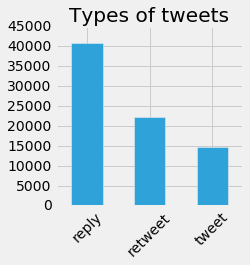

In [125]:
# Home many of all tweets are regular, tweeet, reply
def tweet_type(row):
    if row.retweet == True:
        return "retweet"
    elif row.in_reply == "None":
        return "reply"
    else:
        return "tweet"
# are there any replies and retweets?
a = mytweets.apply(tweet_type,1)
fig=plt.figure(figsize=(3,3))
a.value_counts().plot(kind='bar')
plt.title("Types of tweets")
plt.xticks(rotation=45)
plt.show()
del a

In [126]:
mytweets.head()

,creation,favorites,in_reply,lenguage,retweet,retweet_from,retweets,text,user_id
0,Tue Dec 27 21:37:20 +0000 2016,72,None,en,False,N/A,68,"For every prisoner Obama granted clemency, he ...",2329066872
1,Tue Dec 27 20:08:45 +0000 2016,37,None,en,False,N/A,42,The rhetorical link Kelly makes between terror...,2329066872
2,Tue Dec 27 18:44:50 +0000 2016,32,None,en,False,N/A,57,"Given the assault on reproductive rights, the ...",2329066872
3,Tue Dec 27 18:02:21 +0000 2016,21,None,en,False,N/A,26,The regulations run the gamut from attempts to...,2329066872
4,Tue Dec 27 17:21:11 +0000 2016,110,None,en,False,N/A,124,"And at least one-third of the 40,000 killed by...",2329066872


In [156]:
stop = stopwords.words('english') + stopwords.words('spanish')
other_stop = ['via','&amp;', 'now','one','thing','us', 'will',"it's",'it',"i'm","u","you"]
stop = set(stop + other_stop)
exclude = set(string.punctuation)
def clean_tweets (tweets_string, puntuation=True, lemma=False):
    # gets a string with all tweets and remove RT, links and ids (start with @)
    words_clean = " ".join([word for word in tweets_string.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
    words_clean = " ".join([i for i in words_clean.lower().split() if i not in stop])
    if puntuation:
        words_clean = ''.join(ch for ch in words_clean if ch not in exclude)
    if lemma:    
        words_clean = " ".join(lemma.lemmatize(word) for word in words_clean.split())
    return words_clean
    
# words of ALL TWEETS
words = clean_tweets(' '.join(mytweets['text']))
# words of ALL REGULAR TWEETS 
words_regular = clean_tweets(' '.join(mytweets[(mytweets["in_reply"]=="None") & (mytweets["retweet"]==False)].text))
# words of ONLY RETWEETS
words_rt = clean_tweets(' '.join(mytweets[mytweets["retweet"] == True].text))
# words of ONLY REPLIES
words_reply = clean_tweets(' '.join(mytweets[mytweets["in_reply"] != "None"].text))

ALL TWEETS


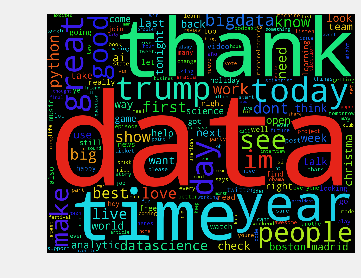

TWEETS


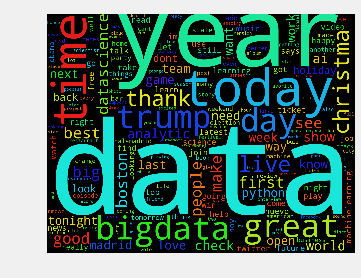

RETWEETS


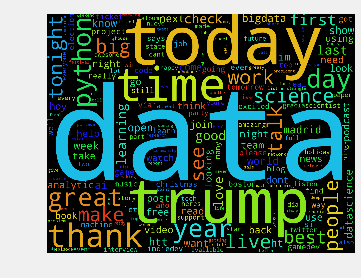

REPLIES


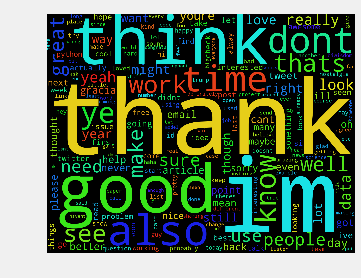

In [150]:
more_stopwords = {'new', 'amp', 'will', 'yet','via','now','one','thing','us','say','aslo','much','gt'}
STOPWORDS = STOPWORDS.union(more_stopwords)

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words)

print("ALL TWEETS")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_regular)

print("TWEETS")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_rt)

print("RETWEETS")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words_reply)

print("REPLIES")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [129]:
def leaders(xs, top=20):
    counts = defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])[:top]

# location of followings
leaders(user_location)

[('', 71),
 ('Madrid', 18),
 ('Boston, MA', 16),
 ('New York, NY', 11),
 ('San Francisco, CA', 9),
 ('Washington, DC', 9),
 ('London', 7),
 ('Worldwide', 7),
 ('Madrid, Spain', 7),
 ('Boston', 7),
 ('España', 7),
 ('NYC', 6),
 ('Mountain View, CA', 6),
 ('New York', 6),
 ('San Francisco', 6),
 ('Barcelona', 5),
 ('Cambridge, MA', 4),
 ('London, England', 4),
 ('Los Angeles, CA', 3),
 ('Massachusetts', 3)]

In [130]:
# hastags
words = clean_tweets(' '.join(mytweets['text']), False) # puntuation is False so we don't delete hastags
leaders([x for x in words.split() if x[0]=='#'])

[('#bigdata', 1051),
 ('#datascience', 874),
 ('#machinelearning', 495),
 ('#python', 453),
 ('#ai', 416),
 ('#analytics', 382),
 ('#halamadrid', 278),
 ('#rmcwc', 242),
 ('#rstats', 227),
 ('#deeplearning', 204),
 ('#gamedev', 198),
 ('#data', 192),
 ('#iot', 190),
 ('#rt', 161),
 ('#indiedev', 154),
 ('#dataviz', 150),
 ('#biwisdom', 149),
 ('#madrid', 135),
 ('#hadoop', 133),
 ('#abdsc', 132)]

In [157]:
#words
words = clean_tweets(' '.join(mytweets['text'])) # puntuation is False so we don't delete hastags
leaders([x for x in words.split()])

[('new', 3464),
 ('data', 3221),
 ('get', 1799),
 ('like', 1713),
 ('great', 1528),
 ('2016', 1516),
 ('time', 1514),
 ('thanks', 1513),
 ('good', 1325),
 ('today', 1323),
 ('see', 1294),
 ('people', 1285),
 ('trump', 1206),
 ('bigdata', 1116),
 ('python', 1112),
 ('best', 1085),
 ('it', 1085),
 ('first', 1065),
 ('day', 1060),
 ('big', 1053)]

In [103]:
#LDA
listoft = mytweets['text'].tolist()
list_clean_tweets = [clean(x,puntuation=True, lemma=True)) for x in listoft]
doc_clean = [x.split() for x in list_clean_tweets]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=5)
#results
for i in (ldamodel.print_topics(num_topics=4, num_words=5)):
    print(i)

In [ ]:
# https://www.quora.com/What-are-some-good-papers-about-topic-modeling-on-Tweets
# https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
# https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
# https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/